In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import numpy as np
from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 14, 'lines.markersize' : 4})

from scipy.optimize import curve_fit
import sys, os
import time, datetime
from datetime import timedelta
import pandas as pd
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
from recon_funcs import *
import h5py

/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/gData.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if gData['rBF'] is not 'custom':


Hi! I imported. 


In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0][-1] = 0
my_cmap = ListedColormap(my_cmap)

In [4]:
def make_MM(x0):
    xshift, yshift =  x0[8], x0[9] 

    # Coordinates that you want to Perspective Transform
    pts1 = np.float32([[0,0],\
                       [0,1024],\
                       [1024,0],\
                       [1024, 1024]])


    # Size of the Transformed Image
    pts2 = np.float32([[0+xshift-x0[0],0 + yshift-x0[1]],\
                       [0+xshift-x0[2],1024 + yshift-x0[3]],\
                       [1024+xshift-x0[4],0 + yshift-x0[5]],\
                       [1024+xshift-x0[6],1024 + yshift-x0[7]]])

    MM = cv2.getPerspectiveTransform(pts1,pts2)
    return MM

X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>120) & (rs<420)]=1
nmask = np.reshape(rebin(rebin(maskhm,4),4),[64**2,])


x,y, = 530,512
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-x)**2+(Y-y)**2)
mask=np.zeros((1024,1024))
mask[rs>1*48]=1

nmask = np.reshape(rebin(rebin(maskhm,4),4),[64**2,]) #rebin later
nnmask = (rebin(np.reshape(nmask, [64,64]))).flatten()
nnmask = rebin(rebin(maskhm,4),4)
#nnmask = (rebin(np.reshape(nmask, [64,64])*(inbg))).flatten()
nnmask[nnmask<0.5] = 0
nnmask[nnmask>=0.5] = 1

maskscale = np.zeros((1024,1024))
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale [(rs>120) & (rs<270)]=1

def make_quads(x0):
    quads=np.ones((1024,1024))
    quads[:512,:512]= x0[0]
    quads[:512,512:]= x0[1]
    quads[512:,:512]= x0[2]
    quads[512:,512:]= x0[3]
    return quads

X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhole=np.zeros((1024,1024))
maskhole[(rs>200) & (rs<332)]=1
maskhole[(Y<512+140)]=0
maskhole[:512,:] = 0

In [5]:
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5') 

gasoff = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/gas_off_X510_112.npy')
inner_bg = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/inner_bg2.npy')
gasoff = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/gas_off_X510_112.npy')
inner_bg = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/inner_bg2.npy')

resid = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Jan/resid_bg_run110_2.npy') #np.load('/cds/home/p/paris/reconVMI_clean/resid_bg_mfgf10_unsat5.npy')
residold = np.load('/cds/home/p/paris/reconVMI_clean/resid_bg_mfgf10.npy')
#for background cal
ims_bg = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Aug/bg_for_cal.npy')
thresh = 32
gfsig = 0.985 #0.985 #0.875
 #int(sys.argv[7])
gfcart = 0.25 #applied to the simulated image to try to make it match the measured
mfcart = 1

In [6]:
runnum = 131 #27
thresh = 32
MM = make_MM([-17.998,-2.74, 17.9, -17.39, 17.86, 8.52, -3.85, 17.9, 11.47, 47.86])
quads = cv2.warpPerspective(make_quads([0.92,0.96219608, 0.96632877, 0.99144247]),MM,(1024,1024))
gmd_max = 100
gmd_min = 0.15
gas_jet = 1
kernel = np.ones(100)/100 #kernel for smoothing function
offset = 50 #offset for CFD
atm_background = None
#ROI for ATM analysis
atm_roi = np.s_[300:400,:]
atm_bins = np.arange(0,1100,20)

In [7]:
#streaked = []
#unstreaked = []
streaked_bin = np.zeros((len(atm_bins),1024,1024))
streaked = np.zeros((1024,1024))
unstreaked = np.zeros((1024,1024))
gmd_streaked = []
gmd_unstreaked = []
atms = []

ds=ps.DataSource(exp = 'tmox51020', run= runnum)
run = next(ds.runs())

opal1 = run.Detector('tmo_opal1') # OPAL camera looking at the holey mirror
gmd = run.Detector("gmd") # gas intensity detector 
timing = run.Detector('timing') # this gives access to evr codes
atmopal = run.Detector('tmo_atmopal')
#ebeam = run.Detector("ebeam")
#opalfzp = run.Detector('tmo_fzpopal') 

printed = -2
for nevent, event in enumerate(run.events()):
    opal1im_i=np.copy(opal1.raw.raw(event))
    evr=timing.raw.eventcodes(event)
    gd_i=gmd.raw.energy(event)
    atmim = atmopal.raw.image(event)
    
    
    gas=evr[70] # did the gas jet fire
    ir_timed=evr[67] # was the ir laser timed
    ir_misttimed=evr[68] # was the ir laser mis-timed

    if opal1im_i is None or gd_i is None or gd_i>gmd_max or gd_i<gmd_min or (gas != gas_jet) or (atmim is None): continue

    im_look=np.copy(opal1.raw.raw(event))  #opal1im_i=np.copy(opal1.raw.image(event)) #doesn't work since update
   
    if ir_misttimed:
        bkgd = atmim[atm_roi] #background image in ROI bin
                    
        if atm_background is None:
            atm_background = bkgd
        else:
            atm_background = 0.9*atm_background+0.1*bkgd
                    
        unstreaked += np.rot90(im_look*mask)
        #unstreaked.append(np.rot90(im_look*mask))
        gmd_unstreaked.append(gd_i)
        print(event.timestamp)
                    
    if ir_timed: 
        if atm_background is None: continue
       
        #streaked.append(np.rot90(im_look*mask))
        streaked +=np.rot90(im_look*mask)
        gmd_streaked.append(gd_i)
                    
        atm_out = np.sum( atmim[atm_roi].astype(float)/atm_background.astype(float) ,0)
        #Analyze with CFD
        ana = atm_out[offset:]-atm_out[:-offset]
        #Smooth output of CFD
        convolved = np.convolve(ana, kernel)
        convolved /= np.max(convolved)
        convolved = convolved[len(kernel):-len(kernel)]
        q = np.argmax(convolved) #index of the peak position
        q_i = np.digitize(q, atm_bins)
        atms.append(q_i)
        streaked_bin[q_i,:,:] =streaked_bin[q_i,:,:]+np.rot90(im_look*mask)
                    
    n = len(gmd_unstreaked)
    if n%20 == 0: 
        if n != printed:
            print('%1.0f unstreaked, %1.0f streaked collected' %(len(gmd_unstreaked),len(gmd_streaked)))
            printed = n
    if n > 100000:
        break

4410506975853110630
4410506975911437691
4410506975969764752
4410506976028091813
4410506976086418874
4410506976144877007
4410506976203204068
4410506976261531129
4410506976319858190
4410506976378185251
4410506976436512312
4410506976494970445
4410506976553297506
4410506976611624567
4410506976669951628
4410506976728278689
4410506980081624758
4410506980139951819
4410506980198278880
4410506980315064074
20 unstreaked, 102 streaked collected
4410506980373391135
4410506980431718196
4410506980490045257
4410506980548503390
4410506980606830451
4410506980665157512
4410506980723484573
4410506980781811634
4410506980840269767
4410506980898596828
4410506980956923889
4410506981015250950
4410506984368597019
4410506984426924080
4410506984485251141
4410506984543709274
4410506984602036335
4410506984660363396
4410506984718690457
4410506984777017518
40 unstreaked, 209 streaked collected
4410506984835475651
4410506984952129773
4410506985010456834
4410506985068783895
4410506985127110956
4410506985243896150
4410

KeyboardInterrupt: 

In [11]:
#streaked = np.array(streaked)
#unstreaked = np.array(unstreaked)
atms = np.array(atms)
gmd_streaked = np.array(gmd_streaked)
gmd_unstreaked = np.array(gmd_unstreaked)

(array([1598., 1854., 2342., 2139., 1476.,  810.,  354.,  131.,   35.,
           6.]),
 array([0.15002441, 0.19031982, 0.23061523, 0.27091064, 0.31120605,
        0.35150146, 0.39179688, 0.43209229, 0.4723877 , 0.51268311,
        0.55297852]),
 <BarContainer object of 10 artists>)

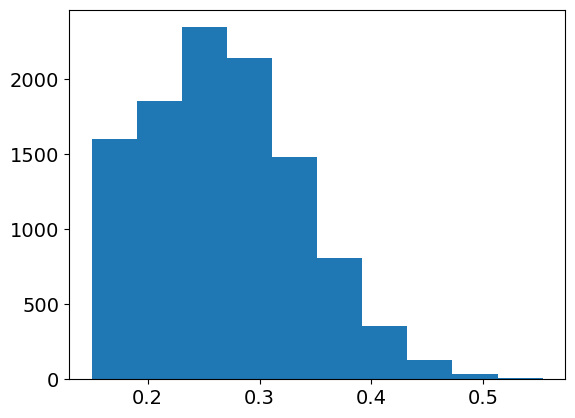

In [16]:
plt.hist(gmd_streaked)

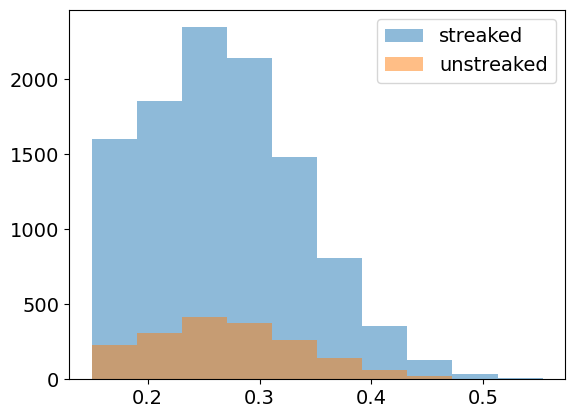

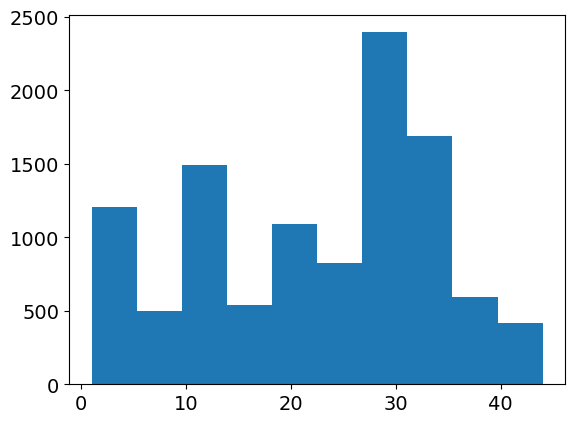

In [12]:
bins = plt.hist(gmd_streaked, label = 'streaked', alpha = 0.5)
plt.hist(gmd_unstreaked, bins[1], label = 'unstreaked', alpha = 0.5)
plt.legend()
plt.show()

plt.hist(atms)
plt.show()

In [13]:
# mean_streaked = cv2.warpPerspective(np.mean(streaked, axis = 0),MM,(1024,1024))
# mean_unstreaked = cv2.warpPerspective(np.mean(unstreaked, axis = 0),MM,(1024,1024))

Text(0.5, 1.0, 'Run 131')

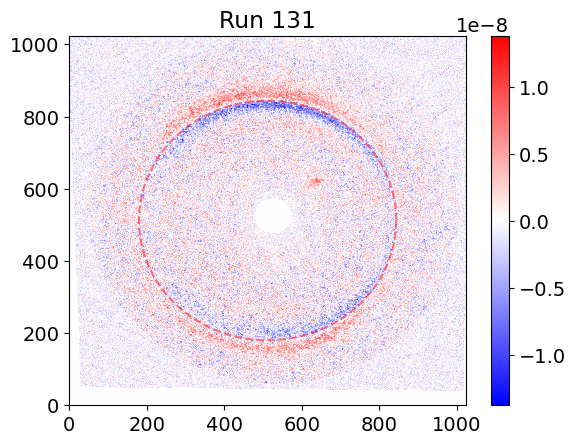

In [14]:
phi_rad = np.linspace(0,360,100)*np.pi/180
plt.pcolormesh(cv2.warpPerspective(streaked/np.sum(streaked)-unstreaked/np.sum(unstreaked),MM,(1024,1024)), cmap = 'bwr')
#plt.pcolormesh(mean_streaked/np.sum(mean_streaked) - mean_unstreaked/np.sum(mean_unstreaked), cmap = 'bwr')
plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar()
plt.title('Run %1.0f' %runnum)

/tmp/ipykernel_32402/887295658.py:4: RuntimeWarning: invalid value encountered in divide
  axs[i].pcolormesh(cv2.warpPerspective(np.mean(streaked_bin[2*i:2*i+1],axis =0)/np.sum(np.mean(streaked_bin[2*i:2*i+1],axis =0))-unstreaked/np.sum(unstreaked),MM,(1024,1024)), cmap = 'bwr')


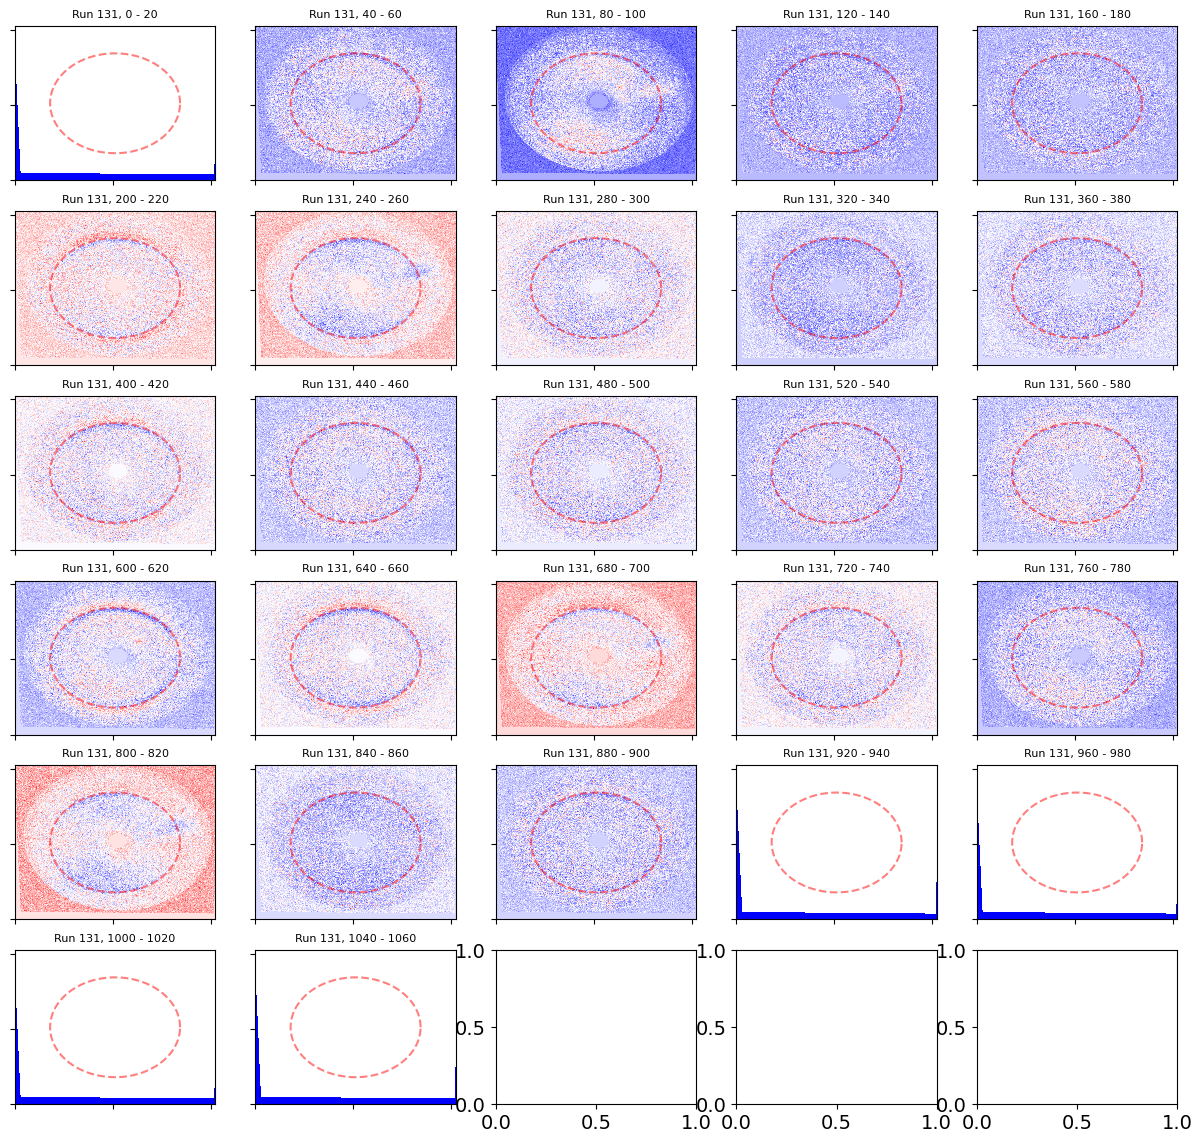

In [15]:
fig,axs = plt.subplots(nrows=6, ncols = 5, figsize = (15,14))
axs = axs.flatten()
for i in range(int((len(atm_bins)-1)/2)):
    axs[i].pcolormesh(cv2.warpPerspective(np.mean(streaked_bin[2*i:2*i+1],axis =0)/np.sum(np.mean(streaked_bin[2*i:2*i+1],axis =0))-unstreaked/np.sum(unstreaked),MM,(1024,1024)), cmap = 'bwr')
    #plt.pcolormesh(mean_streaked/np.sum(mean_streaked) - mean_unstreaked/np.sum(mean_unstreaked), cmap = 'bwr')
    axs[i].plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
    #plt.colorbar()
    axs[i].set_title('Run %1.0f, %1.0f - %1.0f' %(runnum,atm_bins[2*i],atm_bins[2*i+1]), fontsize = 8)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    
plt.show()

In [135]:
q

64

In [136]:
q_i

4

In [139]:
atm_bins[q_i]

80

In [18]:
np.save('unstreaked_131',cv2.warpPerspective(unstreaked,MM,(1024,1024)))